### Импорты

In [445]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor

In [446]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
file_path = "used_cars.csv"

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "taeefnajib/used-car-price-prediction-dataset",
  file_path
)

/tmp/ipython-input-1373441788.py:5: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'used-car-price-prediction-dataset' dataset.


Гипотезы:


1.   Ridge и Lasso улучшат R2 модели за счет увеличения bias
2.   Дерево покажет себя лучше линейной регрессии на метрике RMSE засчет моделирования нелинейных зависимостей
3. Lasso будет уменьшать веса больше, чем Ridge
4. При увеличении глубины дерева будет наблюдаться снижение RMSE на train и увеличение на test
5. Самыми важными фичами для дерева будут пробег и возраст

In [447]:
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


### Корреляционная матрица

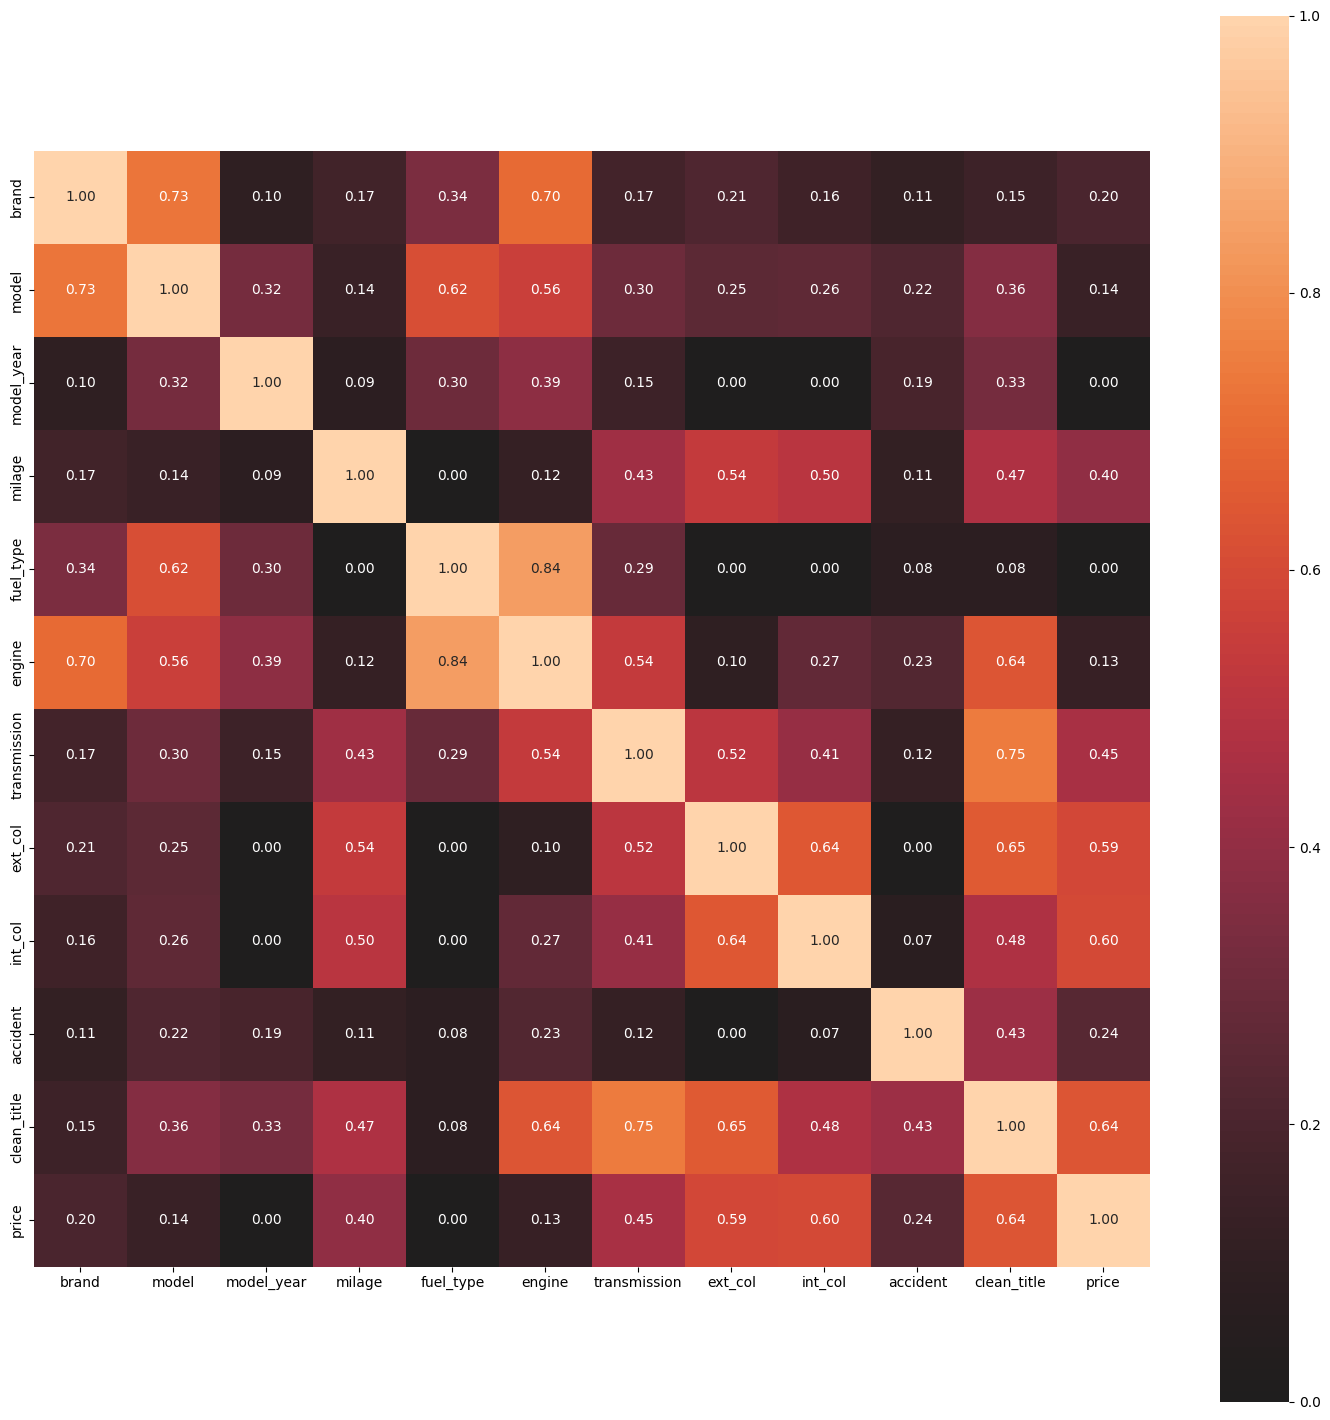

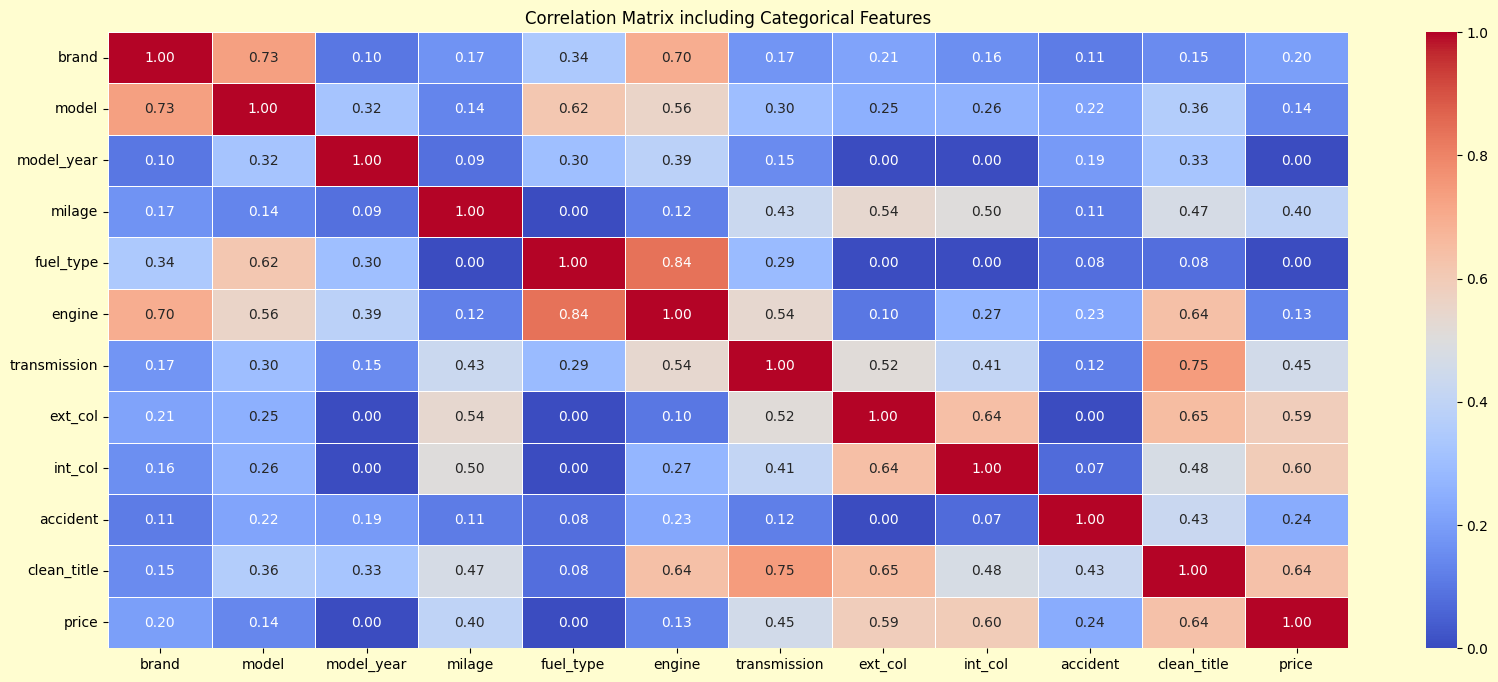

In [448]:
from dython.nominal import associations

associations_df = associations(df, nominal_columns='all', plot=False, nan_replace_value='Unknown')
corr_matrix = associations_df['corr']
plt.figure(figsize=(20, 8))
plt.gcf().set_facecolor('#FFFDD0')
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix including Categorical Features')
plt.show()

In [449]:
# Переводим milage и цену в числовой формат
df['milage'] = df['milage'].str.replace(' mi.', '', regex=False).str.replace(',', '', regex=False).astype(int)
df['price'] = df['price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(int)


In [450]:
df['accident'].value_counts()

accident
None reported                             2910
At least 1 accident or damage reported     986
Name: count, dtype: int64

In [451]:
df['accident'] = (df['accident'] == 'At least 1 accident or damage reported').astype(int)

In [452]:
df['clean_title'] = df['clean_title'].fillna(0)
df['clean_title'] = (df['clean_title'] == 'Yes').astype(int)

In [453]:
today = date.today()
df['model_year'] = today.year - df['model_year']
df = df.rename(columns={'model_year': 'age'})

In [454]:
df.describe().round(2)

,age,milage,accident,clean_title,price
count,4009.00,4009.00,4009.00,4009.00,4009.00
mean,10.48,64717.55,0.25,0.85,44553.19
std,6.10,52296.60,0.43,0.36,78710.64
min,2.00,100.00,0.00,0.00,2000.00
25%,6.00,23044.00,0.00,1.00,17200.00
50%,9.00,52775.00,0.00,1.00,31000.00
75%,14.00,94100.00,0.00,1.00,49990.00
max,52.00,405000.00,1.00,1.00,2954083.00


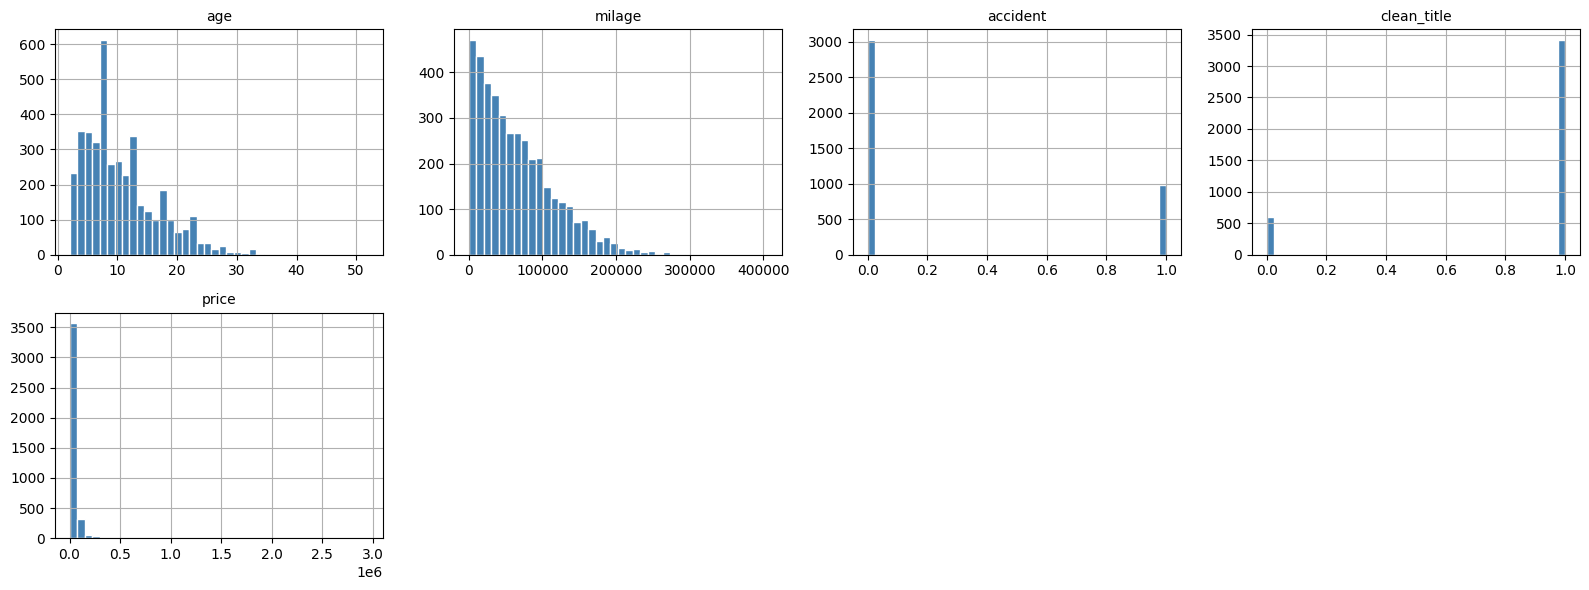

In [455]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

n_cols = len(numeric_cols)
n_rows = (n_cols + 3) // 4
fig, axes = plt.subplots(n_rows, 4, figsize=(16, n_rows * 3))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    df[col].hist(bins=40, ax=axes[i], color='steelblue', edgecolor='white')
    axes[i].set_title(col, fontsize=10)

for j in range(len(numeric_cols), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

### Удаление выбросов


In [456]:
q1_p = df['price'].quantile(0.25)
q3_p = df['price'].quantile(0.75)
iqr_p = q3_p - q1_p
upper_bound_p = q3_p + 1.5 * iqr_p
lower_bound_p = q1_p - 1.5 * iqr_p

q1_m = df['milage'].quantile(0.25)
q3_m = df['milage'].quantile(0.75)
iqr_m = q3_m - q1_m
upper_bound_m = q3_m + 1.5 * iqr_m
lower_bound_m = q1_m - 1.5 * iqr_m

In [457]:
df = df[(df['price'] >= lower_bound_p) & (df['price'] <= upper_bound_p)]
df = df[(df['milage'] >= lower_bound_m) & (df['milage'] <= upper_bound_m)]

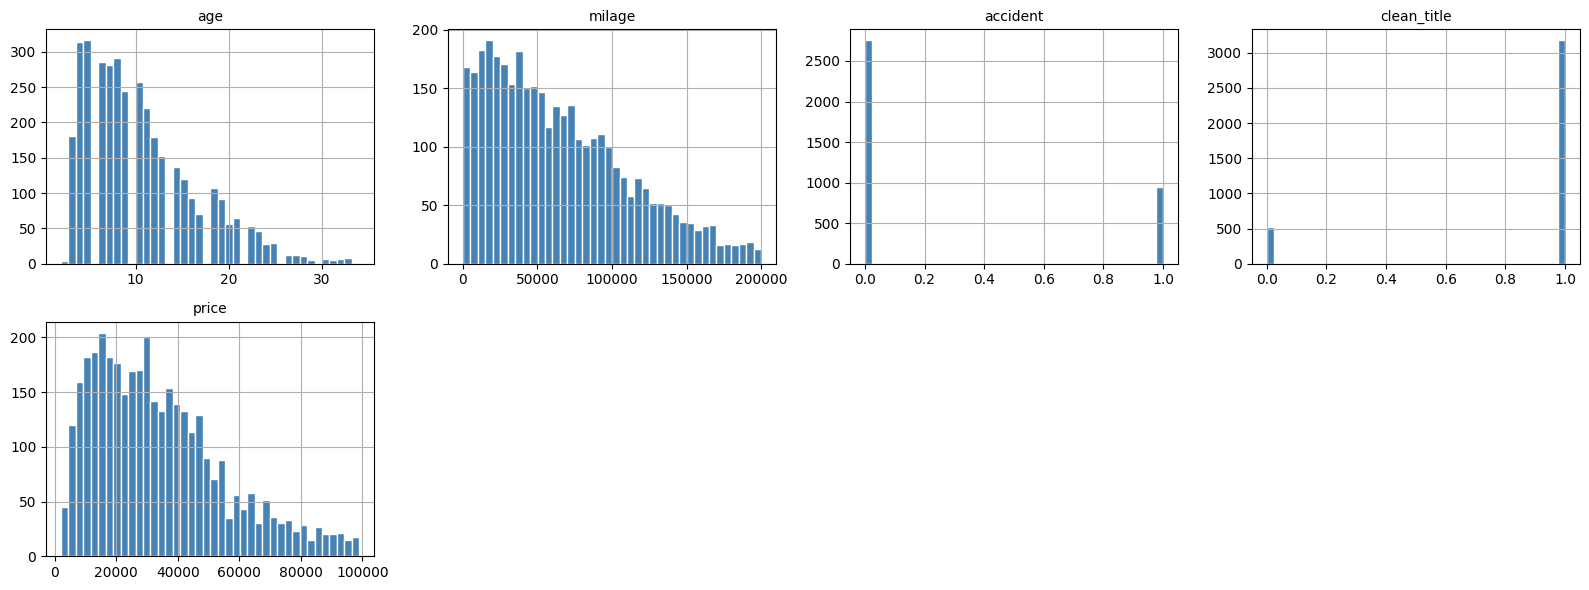

In [458]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

n_cols = len(numeric_cols)
n_rows = (n_cols + 3) // 4
fig, axes = plt.subplots(n_rows, 4, figsize=(16, n_rows * 3))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    df[col].hist(bins=40, ax=axes[i], color='steelblue', edgecolor='white')
    axes[i].set_title(col, fontsize=10)

for j in range(len(numeric_cols), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [459]:
df.isnull().sum()

brand             0
model             0
age               0
milage            0
fuel_type       163
engine            0
transmission      0
ext_col           0
int_col           0
accident          0
clean_title       0
price             0
dtype: int64

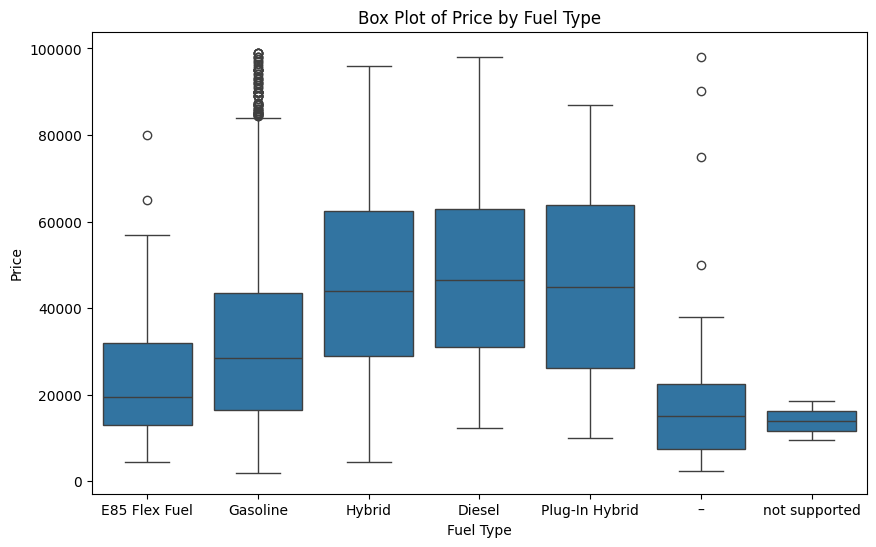

In [460]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='fuel_type', y='price', data=df)
plt.title('Box Plot of Price by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Price')
plt.show()

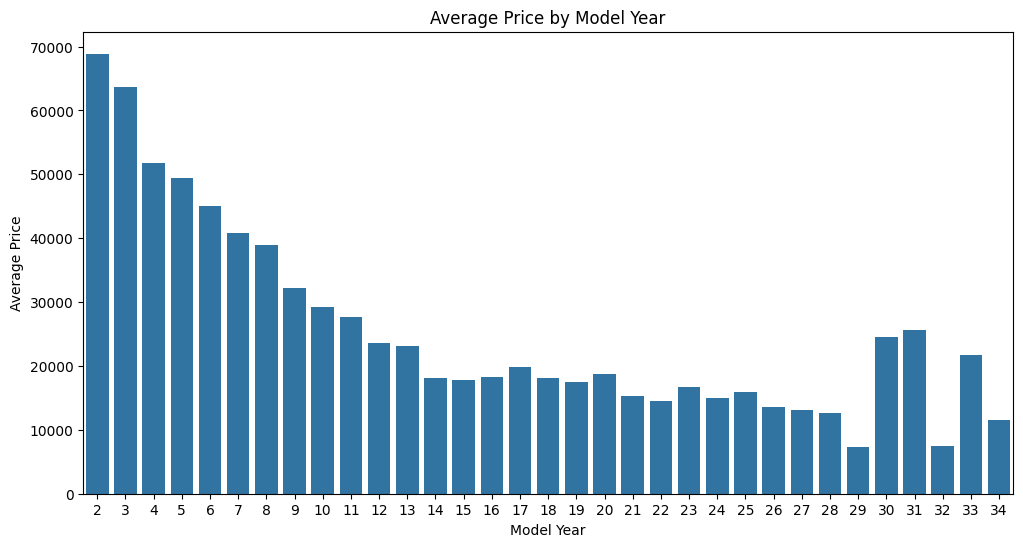

In [461]:
plt.figure(figsize=(12, 6))
sns.barplot(x='age', y='price', data=df, errorbar=None)
plt.title('Average Price by Model Year')
plt.xlabel('Model Year')
plt.ylabel('Average Price')

plt.show()

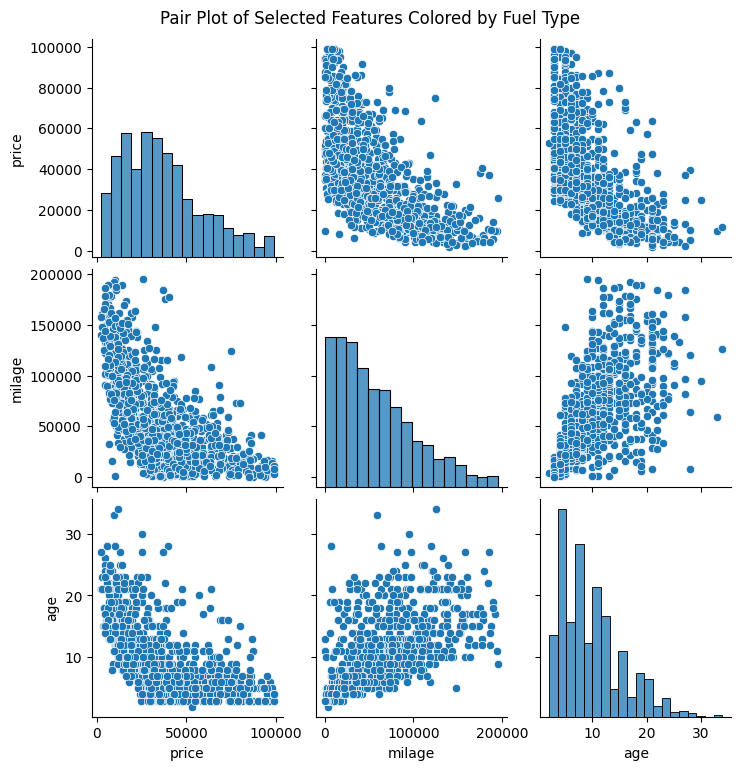

In [462]:
x = df[:1000]
sns.pairplot(x[['price', 'milage', 'age']])
plt.suptitle('Pair Plot of Selected Features Colored by Fuel Type', y=1.02)
plt.show()

### Кодирование категориальных признаков

In [463]:
df = pd.get_dummies(df, columns=['fuel_type'], drop_first=True)


In [464]:
df.columns.tolist()

['brand',
 'model',
 'age',
 'milage',
 'engine',
 'transmission',
 'ext_col',
 'int_col',
 'accident',
 'clean_title',
 'price',
 'fuel_type_E85 Flex Fuel',
 'fuel_type_Gasoline',
 'fuel_type_Hybrid',
 'fuel_type_Plug-In Hybrid',
 'fuel_type_not supported',
 'fuel_type_–']

In [465]:
def is_automatic(x):
    x = str(x).strip().lower()
    if 'auto' in x or 'a/t' in x or 'automatic' in x:
        return 1
    else:
        return 0

df['is_automatic'] = df['transmission'].apply(is_automatic)


In [466]:
df.drop('transmission', axis=1, inplace=True)


In [467]:
# Engine имеет сильную корреляцию с fuel type
df.drop('engine', axis=1, inplace=True)

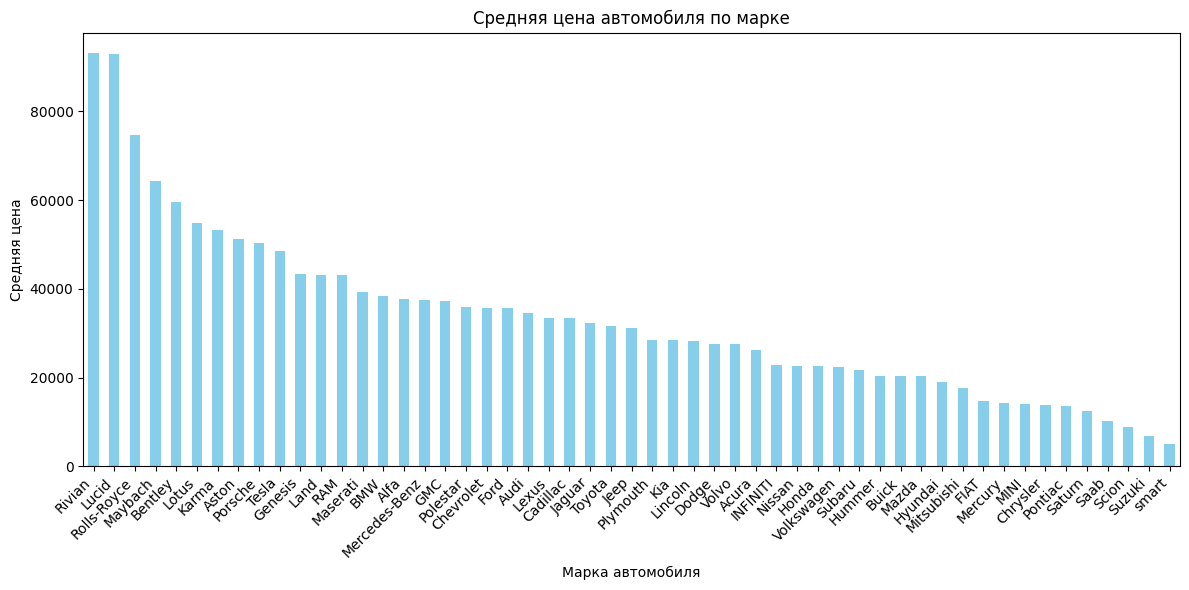

In [468]:
avg_price_by_brand = df.groupby('brand')['price'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
avg_price_by_brand.plot(kind='bar', color='skyblue')
plt.ylabel('Средняя цена')
plt.xlabel('Марка автомобиля')
plt.title('Средняя цена автомобиля по марке')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [469]:
median_prices = df.groupby('brand')['price'].median()
premium_brands = median_prices[median_prices > median_prices.quantile(0.75)].index.tolist()
lowcost_brands = median_prices[median_prices < median_prices.quantile(0.25)].index.tolist()



In [470]:
df['segment'] = np.where(df['brand'].isin(premium_brands), 'Premium',
                 np.where(df['brand'].isin(lowcost_brands), 'Lowcost', 'Mid'))

In [471]:
df = pd.get_dummies(df, columns=['segment'], drop_first=True)


In [472]:
df=df.drop('brand', axis=1)
df=df.drop('model', axis=1)


In [473]:
ext_price_mean = df.groupby('ext_col')['price'].mean()
ext_price_mean = ext_price_mean.sort_values()

bins = [ext_price_mean.min()-1, ext_price_mean.quantile(0.33), ext_price_mean.quantile(0.66), ext_price_mean.max()+1]
labels = ['Low', 'Mid', 'High']
df['ext_col_segment'] = pd.cut(df['ext_col'].map(ext_price_mean), bins=bins, labels=labels)
df['ext_col_segment'] = pd.cut(df['ext_col'].map(ext_price_mean), bins=bins, labels=labels)
df = pd.get_dummies(df, columns=['ext_col_segment'], drop_first=True)
df.drop('ext_col', axis=1, inplace=True)
df.drop('int_col', axis=1, inplace=True)


In [474]:
df.describe()

,age,milage,accident,clean_title,price,is_automatic
count,3696.000000,3696.000000,3696.000000,3696.000000,3696.000000,3696.000000
mean,10.554654,64898.857413,0.255411,0.858766,33947.139881,0.785985
std,5.966641,46729.605688,0.436151,0.348310,21311.687767,0.410193
min,2.000000,100.000000,0.000000,0.000000,2000.000000,0.000000
25%,6.000000,26071.250000,0.000000,1.000000,17000.000000,1.000000
50%,9.000000,55660.500000,0.000000,1.000000,29995.000000,1.000000
75%,14.000000,94533.500000,1.000000,1.000000,45999.000000,1.000000
max,34.000000,200000.000000,1.000000,1.000000,99000.000000,1.000000


### Обучаем модель Линейной Регрессии

In [475]:
X = df.drop(columns=['price'])
y = df['price']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [476]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_val_pred = lr_model.predict(X_val)


In [477]:
mae = mean_absolute_error(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_val_pred)

In [478]:
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.3f}")

MAE: 11359.19
MSE: 216462009.07
RMSE: 14712.65
R2: 0.531


### Lasso + Ridge

In [479]:
models_reg = {
    'OLS': LinearRegression(),
    'Ridge (α=1)': Ridge(alpha=1),
    'Ridge (α=100)': Ridge(alpha=100),
    'Lasso (α=1)': Lasso(alpha=1),
    'Lasso (α=100)': Lasso(alpha=100),
    'ElasticNet': ElasticNet(alpha=1, l1_ratio=0.5),
}

results_reg = []
for name, model in models_reg.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    results_reg.append({
        'Model': name,
        'RMSE': np.sqrt(mean_squared_error(y_val, y_pred)),
        'MAE': mean_absolute_error(y_val, y_pred),
        'R²': r2_score(y_val, y_pred),
    })

pd.DataFrame(results_reg).set_index('Model').round(2)

,RMSE,MAE,R²
Model,,,
OLS,14712.65,11359.19,0.53
Ridge (α=1),14714.12,11359.60,0.53
Ridge (α=100),14907.11,11495.08,0.52
Lasso (α=1),14713.70,11359.98,0.53
Lasso (α=100),14806.81,11406.36,0.53
ElasticNet,15476.37,11862.59,0.48


1. Существенного изменения R2 не произошло

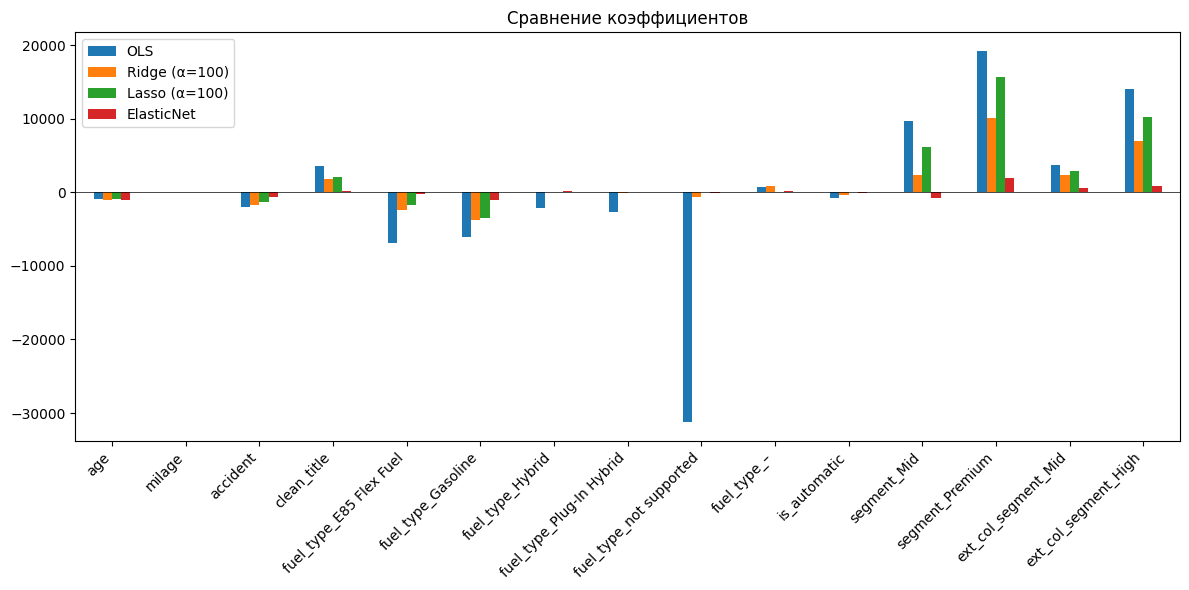

In [480]:
coefs = pd.DataFrame({
    name: model.coef_ for name, model in models_reg.items()
}, index=X.columns)

fig, ax = plt.subplots(figsize=(12, 6))
coefs[['OLS', 'Ridge (α=100)', 'Lasso (α=100)', 'ElasticNet']].plot.bar(ax=ax)
ax.set_title('Сравнение коэффициентов')
ax.axhline(0, color='black', linewidth=0.5)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

3. Lasso не так сильно менял признаки, как ridge, т.к. ridge больше штрафует за большие веса, которые и наблюдались до применения регуляризации

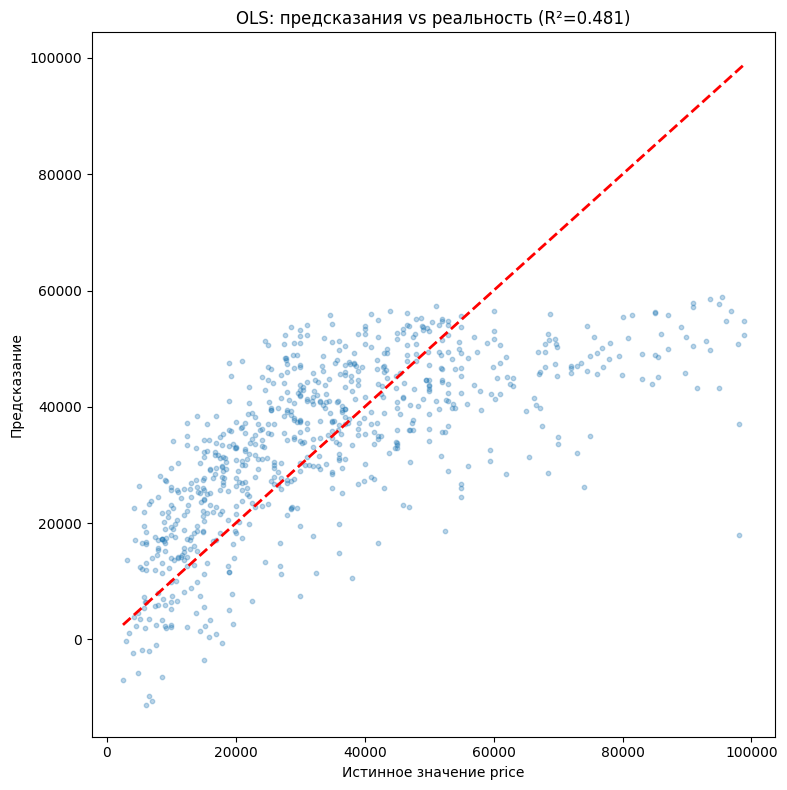

In [481]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(y_val, y_pred, alpha=0.3, s=10)
lims = [y_val.min(), y_val.max()]
ax.plot(lims, lims, 'r--', linewidth=2)
ax.set_xlabel('Истинное значение price')
ax.set_ylabel('Предсказание')
ax.set_title(f'OLS: предсказания vs реальность (R²={r2_score(y_val, y_pred):.3f})')
plt.tight_layout()
plt.show()

### Дерево для регрессии

In [485]:
dt_reg = DecisionTreeRegressor(max_depth=8, random_state=42, criterion='squared_error')
dt_reg.fit(X_train, y_train)
y_pred_dt_reg = dt_reg.predict(X_val)
y_pred_train = dt_reg.predict(X_train)


print(f"RMSE Train: {rmse_train:.4f}")

pd.DataFrame({
    'RMSE': [np.sqrt(mean_squared_error(y_val, y_pred_dt_reg))],
    'RMSE_train': np.sqrt(mean_squared_error(y_train, y_pred_train)),
    'MAE': [mean_absolute_error(y_val, y_pred_dt_reg)],
    'R²': [r2_score(y_val, y_pred_dt_reg)],
}, index=['DecisionTree Regressor']).round(4)

RMSE Train: 11929.7254


,RMSE,RMSE_train,MAE,R²
DecisionTree Regressor,14860.0714,11929.7254,10908.5276,0.5217


2. Метрика RMSE оказалась хуже у дерева


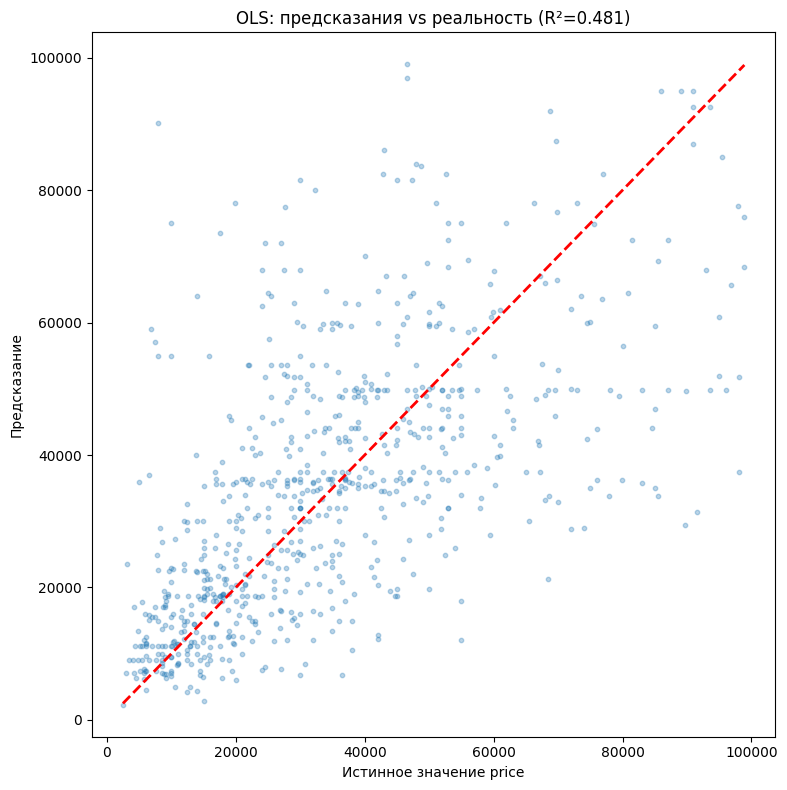

In [487]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(y_val, y_pred_dt_reg, alpha=0.3, s=10)
lims = [y_val.min(), y_val.max()]
ax.plot(lims, lims, 'r--', linewidth=2)
ax.set_xlabel('Истинное значение price')
ax.set_ylabel('Предсказание')
ax.set_title(f'OLS: предсказания vs реальность (R²={r2_score(y_val, y_pred):.3f})')
plt.tight_layout()
plt.show()


In [489]:
dt_reg_deep = DecisionTreeRegressor(max_depth=15, random_state=42, criterion='squared_error')
dt_reg_deep.fit(X_train, y_train)
y_pred_dt_reg = dt_reg_deep.predict(X_val)
y_pred_train = dt_reg_deep.predict(X_train)


print(f"RMSE Train: {rmse_train:.4f}")

pd.DataFrame({
    'RMSE': [np.sqrt(mean_squared_error(y_val, y_pred_dt_reg))],
    'RMSE_train': np.sqrt(mean_squared_error(y_train, y_pred_train)),
    'MAE': [mean_absolute_error(y_val, y_pred_dt_reg)],
    'R²': [r2_score(y_val, y_pred_dt_reg)],
}, index=['DecisionTree Regressor']).round(4)

RMSE Train: 11929.7254


,RMSE,RMSE_train,MAE,R²
DecisionTree Regressor,17903.306,6761.354,12856.9531,0.3058


4. Дерево переобучилось: rmse на train снизился, на test увеличился

In [490]:
import pandas as pd

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': dt_reg.feature_importances_
}).sort_values(by='importance', ascending=False)

feature_importance


,feature,importance
1,milage,0.690001
0,age,0.156615
12,segment_Premium,0.052077
5,fuel_type_Gasoline,0.023127
11,segment_Mid,0.021495
14,ext_col_segment_High,0.013220
10,is_automatic,0.012649
13,ext_col_segment_Mid,0.011037
3,clean_title,0.010063
2,accident,0.004002


5. Пробег и возраст стали самыми важными переменными